In [1]:
# Setup

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Linear Regression

- Poor performance when number of features grows large (eg., 100,000)
- As long as it can fit in the memory, it handles large training sets efficiently
- Once trained, predictions are very fast: 2x the number of features OR 2x the number instances = 2x times the processing time

In [2]:
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

In [3]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance 
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [5]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance 
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

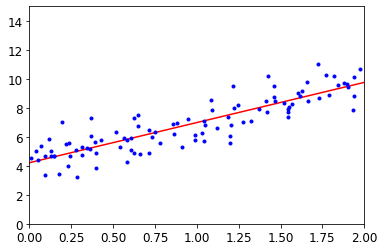

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

using sklearn LinearRegression

In [7]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [8]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

In [9]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.21509616],
       [2.77011339]])

In [10]:
np.linalg.pinv(X_b).dot(y)

array([[4.21509616],
       [2.77011339]])

## Gradient Descent

- Tweaks parameters interatively in order to minimize a cost function
- Features should have a similar scale (using StandardScaler), or it will take a long time to converge

### Batch Gradient Descent

- Computes a partial derivative in a batch, using a learning rate multiplied by the gradient vector
- Uses the whole training set to compute the gradients at every step (very slow)

In [11]:
eta = 0.1 # learning rate 
n_iterations = 1000 
m = 100
theta = np.random.randn(2,1) # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y) 
    theta = theta - eta * gradients

In [12]:
theta

array([[4.21509616],
       [2.77011339]])

### Stochastic Gradient Descent

- Picks a random instance in the training set at every step and computes the gradient based only on that single instance (much faster than batch gradient descent)
- Due to random nature, it is less regular than batch gradient descent, bouncing up and down and decreasing to the minimum only on average
- It reaches to good parameter values, but usually not the optimal
- Better chance to find the global minima, when comparing to batch gradient descent, specially on irregular cost functions
- By gradually reducing the learning rate, we can make quick progress and escape the local minima at the beggining, and while the learning rate gets smaller, it helps settle at the global minimum.

In [13]:
n_epoch = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1) # random initialization

for epoch in range(n_epoch):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients =2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [14]:
theta

array([[4.18475289],
       [2.73036719]])

using sklearn SGDRegressor

In [15]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [16]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.22609703]), array([2.79227913]))

### Mini-batch Gradient Descent

- Instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches
- Can get a performance boost from hardware optimization
- Less erratic than Stochastic GD and usualy deliver better minimum values, but it might get stuck on local minima.

## Polynomial Regression

Let's try to use a linear model to fit nonlinear data!

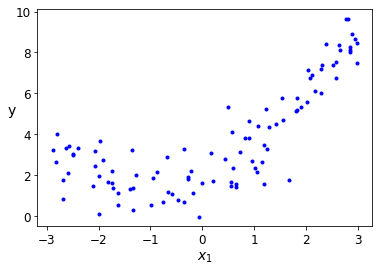

In [17]:
#  generate some nonlinear data, based on a simple quadratic equation

m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.xlabel("$x_1$")
plt.ylabel("y", rotation = 0)
plt.plot(X, y, "b.")

We can't fit a straight line here...<br>
Let's use PolynomialFeatures class to transform our training data, adding the square of each feature in the training set as a new feature

In [18]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([2.94407494])

In [19]:
X_poly[0]

array([2.94407494, 8.66757727])

X_poly now has the original feature (1.79193468) and the squared (3.21102991)<br>
Now, we can fit a LinearRegression model

In [20]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.89554823]), array([[0.95707476, 0.49025797]]))

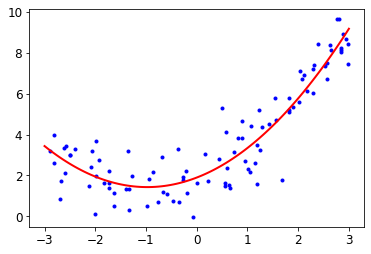

In [21]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth = 2, label = "Predictions")

## Learning Curves

How to know if we are overfitting or underfitting? Check the learning curve:

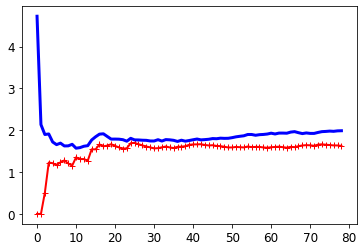

In [22]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2) 
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
        
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")

lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

Learning curve of a 10th degree polynomial model

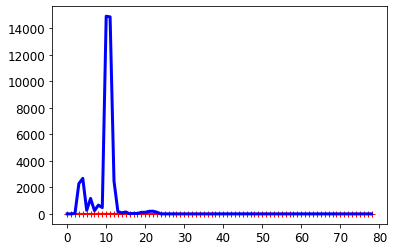

In [23]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 10, include_bias = False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)

## Regularized Linear Models

How to reduce overfitting?<br>
We need to regularize the model (constrain it): the less freedom, less likely to overfit.<br>
For polynomial models, we can reduce the number of polynomial degrees.<br>
For linear models, we can constrain the weight of the model.

### Ridge Regression
Tikhonov regularization

In [24]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.07720864]])

In [25]:
# using Stochastic Gradient Descent

sgd_reg = SGDRegressor(penalty = 'l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.08461165])

### Lasso Regression
Least Absolute Shrinkage and Selection Operator Regression

In [26]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.04247738])

In [27]:
# using Stochastic Gradient Descent

sgd_reg = SGDRegressor(penalty = 'l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.04315719])

### Elastic Net
Middle ground between Ridge and Lasso

In [28]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([5.04191364])

In [29]:
# using Stochastic Gradient Descent

sgd_reg = SGDRegressor(penalty = 'elasticnet')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.05437713])

Preference:
- Ridge is a good default
- If only a few features are useful, choose between Elastic or Lasso because they reduce useless features' weights down to zero
- In general, Elastic is prefered over Lasso because Lasso may behave erratically when the number of featueres is greater than the number of training instances or when several features are strongly correlated

### Early Stopping
Stop training as soon as the validation error reaches a minimum.

In [30]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

# prepare the data
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree = 90, include_bias = False)),
        ("std_scaler", StandardScaler())
    ])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, tol = -np.infty, warm_start = True,
                       penalty = None, learning_rate = "constant", eta0 = 0.0005)

minimum_val_error = float("inf") 
best_epoch = None
best_model = None

for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train.ravel()) # continues where it left off 
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)

    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = clone(sgd_reg)

In [31]:
best_epoch

507

In [32]:
best_model

SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True)

In [33]:
minimum_val_error

1.0523248025107421

## Logistic Regression
Commonly used to estimate the probability that an instance belongs to a particular class.

### Estimating Probabilities
Just like a Linear Regression model, a Logistic Regression model computes the weighted sum of the input (plus a bias term), but instead of outputting the result directly like the Linear Regression model does, it ouputs the logistic of this result (a number between 0 and 1).

### Training and Cost Function
The objective of training is to set the parameter vector θ so that the model estimates high probabilities for positive instances (y = 1) and low probabilities for negative instances (y = 0).

### Decision Boudaries
Using the famous iris dataset, let's try to illustrate Logistic Regression

- Task: Build a classifier to detect the Iris virginica type based only on the petal width feature.

In [34]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [35]:
# finding out where is the petal width
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [36]:
# finding out where the Iris virginica type is located
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [37]:
X = iris['data'][:,3:] # petal width
y = (iris['target'] == 2).astype(np.int) # 1 if Iris virginica, else 0

Training a Logistic Regression model

In [38]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

Let’s look at the model’s estimated probabilities for flowers with petal widths varying from 0 cm to 3 cm

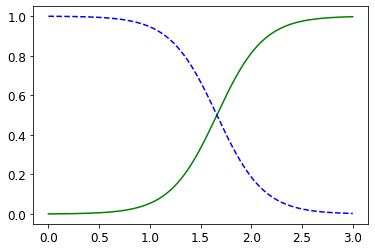

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:, 1], "g-")
plt.plot(X_new, y_proba[:, 0], "b--")

/Users/bruno/Desktop/hands-on-ML_studies-diary/my_env/lib/python3.7/site-packages/matplotlib/patches.py:1327: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  verts = np.dot(coords, M) + (x + dx, y + dy)


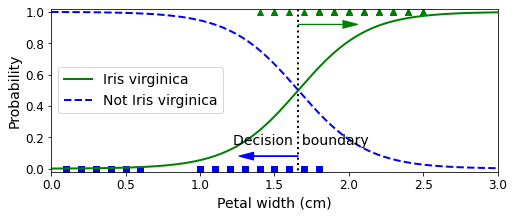

In [40]:
# fancy figure displayed in the book

X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

The petal width of Iris virginica flowers (represented by triangles) ranges from 1.4 cm to 2.5 cm, while the other iris flowers (represented by squares) generally have a smaller petal width, ranging from 0.1 cm to 1.8 cm.

There is a decision boundary at around 1.6 cm where both probabilities are equal to 50%: if the petal width is higher than 1.6 cm, the classifier will predict that the flower is an Iris virginica, and otherwise it will predict that it is not (even if it is not very confident)

In [41]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

### Softmax Regression
The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers.

When given an instance x, the Softmax Regression model first computes a score sk(x) for each class k, then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores.

- Task: Use Softmax Regression to classify the iris flowers into all three classes.

In [42]:
X = iris['data'][:, (2, 3)] # petal length, petal width
y = iris['target']

In [43]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

What happens if we ask this model what type of iris is, based on a 5cm lenght and 2cm width parameter?

In [44]:
softmax_reg.predict([[5, 2]])

array([2])

In [45]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])

It tells us that is is Iris virginica, with 94.2% probability (or Iris versicolor, with 5.8% probability)